# Convolve a simulated image wit the XMM PSF

In [1]:
import os

from astropy.io import fits
from astropy.convolution import convolve, convolve_fft

from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u

import numpy as np

import matplotlib.pylab as plt
%matplotlib inline

import aplpy

from photutils import SkyCircularAperture, SkyCircularAnnulus, aperture_photometry

/Users/ivaltcha/miniconda3/envs/py37/lib/python3.7/site-packages/mpl_toolkits/axes_grid/__init__.py:12: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  obj_type='module')


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 1. Read the FITS files of the image and the PSF

First we read the simulated cluster image `pn_500_7000_simulated.fits`, produced using the double-$\beta$ model (Jukka's parameters). The image is generated in another notebook `simulate_xmm_cluster.ipynb`.

Then we read the PSF image produced with `XMM-SAS` function:
```
psfgen image=pn_500_7000_simulated.fits withimage=yes \
    level=ELLBETA energy=1500 x=207.220833 y=26.590278 \
    coordtype=EQPOS xsize=199 ysize=199 output=pn_psf.fits
```
This should be the most accurate represetation of the actual PSF.

In [3]:
home = os.path.expanduser('~')
hdu1 = fits.open('../data/pn_500_7000_simulated_nomask.fits')
psf = fits.open('../data/pn_psf.fits.gz')

In [4]:
psf_wcs = WCS(psf[0].header)
print (psf_wcs.pixel_scale_matrix[1,1]*3600.0)

1.0000000000000009


In [5]:
wcs = WCS(hdu1[0].header)
print (wcs.pixel_scale_matrix[1,1]*3600.0)

1.0000000000000009


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


## 2. Define the sky apertures
The files were read and the next step is to set up the apertures. Centred on the cluster centre.

In [6]:
wcs = WCS(hdu1[0].header)
arcmin2pix = wcs.pixel_scale_matrix[1,1]*60.0
center = SkyCoord(207.2208333,26.59027778,unit=(u.deg,u.deg),frame='icrs')
aperture1 = SkyCircularAperture(center, r=1. * u.arcmin)
aperture2 = SkyCircularAperture(center, r=2. * u.arcmin)
aperture4 = SkyCircularAperture(center, r=4. * u.arcmin)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [7]:
# Let's check the PSF EEF for 1, 2 and 4 arcmin
psf_wcs = WCS(psf[0].header)
# we need to normalise the PSF
psf_tot = np.sum(psf[0].data)
psf_norm = psf[0].data/psf_tot
psf1 = aperture_photometry(psf_norm, aperture1,wcs=psf_wcs)
psf2 = aperture_photometry(psf_norm, aperture2,wcs=psf_wcs)
psf4 = aperture_photometry(psf_norm, aperture4,wcs=psf_wcs)

In [8]:
psf_flux1 = psf1['aperture_sum'][0]
psf_flux2 = psf2['aperture_sum'][0]
psf_flux4 = psf4['aperture_sum'][0]
print ("PSF EEF in 1, 2 and 4 arcmin aperture ", psf_flux1,psf_flux2,psf_flux4)

PSF EEF in 1, 2 and 4 arcmin aperture  0.9616601379655427 0.9993801225589012 1.0000000298228002


## 3. Define the sky mask

Next we define a sky pixel mask, so all pixels outside `rmask` will be set to zero.

In [10]:
# grid to mask the outside area
rmask = 1.0 # arcmin, the cool core scale
nx,ny = hdu1[0].data.shape
y, x = np.mgrid[0:ny, 0:nx]
xy = wcs.wcs_world2pix(center.ra.value,center.dec.value,1)
y = y - xy[1]
x = x - xy[0]
rx = np.sqrt(x*x + y*y)
rmax = rmask/arcmin2pix
ix = np.where(rx >= rmax)
image_mask = hdu1[0].data.copy()
image_mask[ix] = 0.0

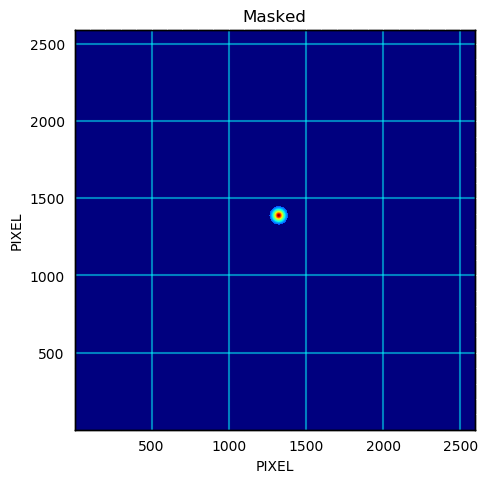

In [11]:
fig = plt.figure(figsize=(10,10),dpi=100)
f0 = aplpy.FITSFigure(image_mask, figure=fig, subplot=[0.1,0.1,0.4,0.4])
f0.show_colorscale(vmin=0,vmax=np.max(image_mask))
#f0.show_colorscale(vmin=1,vmax=100,stretch='log')
f0.set_title('Masked')
f0.add_grid()
f0.grid.set_color('cyan')
f0.grid.set_alpha(0.5)


## 4. Perform the aperture photometry

And we intergate the flux within the previously defined apertures using `photutils` package. 

In [12]:
photo1 = aperture_photometry(hdu1[0].data, aperture1,wcs=wcs)
photo2 = aperture_photometry(hdu1[0].data, aperture2,wcs=wcs)
photo4 = aperture_photometry(hdu1[0].data, aperture4,wcs=wcs)
ap_flux1 = photo1['aperture_sum'][0]
ap_flux2 = photo2['aperture_sum'][0]
ap_flux4 = photo4['aperture_sum'][0]
annulus = ap_flux4 - ap_flux2

Print some numbers as a result of the calculations:

In [13]:
print ("Total counts in aperture4: {}".format(ap_flux4))
print ("Total counts in aperture2: {}".format(ap_flux2))
print ("Total counts in aperture1: {}".format(ap_flux1))
print ("Total counts in annulus: {}".format(annulus))
ratio = ap_flux2/annulus
print ("Ratio center to annulus: {}".format(ratio))

Total counts in aperture4: 326473193.6987109
Total counts in aperture2: 217270253.1951752
Total counts in aperture1: 120203645.50280486
Total counts in annulus: 109202940.50353572
Ratio center to annulus: 1.9896007579405843


So, within the central 2 arcmin aperture we have twice as many counts as in the annulus from 2 to 4 arcmin. This can probably be derived analytically with the double-$\beta$ model.

## 5. Convolve the masked image with the PSF

I use the FFT convolution. If the masked image or the PSF contain `NaN` then this probably will not work. Luckyly this is not the case for the the simulated image and the generated PSF, so we can do this as it is much faster than the brute-force convolution.

In [15]:
result = convolve_fft(image_mask,psf_norm)
#
# save to a file
#
hdu1[0].data = result
hdu1.writeto('../data/convolved_image.fits',overwrite=True)

## 6. Check the convolution

We check the result visually, using `APLpy`.

INFO: Auto-setting vmin to  2.218e-07 [aplpy.core]
INFO: Auto-setting vmax to  1.816e-03 [aplpy.core]


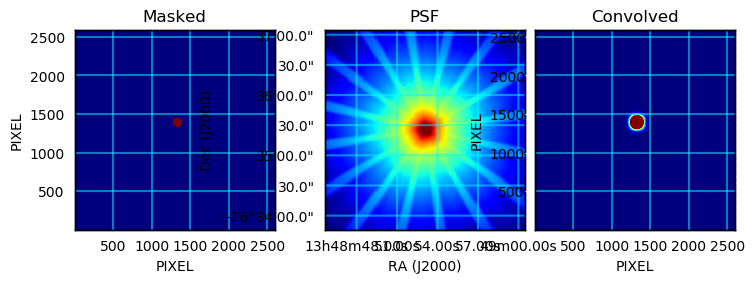

In [16]:
fig = plt.figure(figsize=(10,10),dpi=100)
f0 = aplpy.FITSFigure(image_mask, figure=fig, subplot=[0.1,0.1,0.2,0.2])
f0.show_colorscale(vmin=0,vmax=210)
#f0.show_colorscale(vmin=1,vmax=100,stretch='log')
f0.set_title('Masked')
f0.add_grid()
f0.grid.set_color('cyan')
f0.grid.set_alpha(0.5)
f0x = aplpy.FITSFigure(psf, figure=fig, subplot=[0.35,0.1,0.2,0.2])
f0x.show_colorscale(stretch='log')
f0x.set_title('PSF')
f0x.add_grid()
f0x.grid.set_color('cyan')
f0x.grid.set_alpha(0.5)
f1 = aplpy.FITSFigure(result, figure=fig, subplot=[0.56,0.1,0.2,0.2])
f1.show_colorscale(vmin=0,vmax=210)
#f1.show_colorscale(vmin=0.001,vmax=1,stretch='log')
#f1.show_colorscale(stretch='log')
f1.set_title('Convolved')
f1.add_grid()
f1.grid.set_color('cyan')
f1.grid.set_alpha(0.5)
#f0.show_circles(aperture1.positions.ra.value,aperture1.positions.dec.value,\
#                    aperture1.r.value/60.0,edgecolor='black')
#f0.show_circles(aperture2.positions.ra.value,aperture2.positions.dec.value,\
#                    aperture2.r.value/60.0,edgecolor='blue')
#f0.recenter(aperture.positions.ra.value,aperture.positions.dec.value,radius=8.0/60.0)
#f0.show_markers(aperture.positions.ra.value,aperture.positions.dec.value)
#f0.tick_labels.set_xformat('hh:mm:ss.s')
#f0.tick_labels.set_yformat('dd:mm:ss')
#f0.hide_ytick_labels()
#f0.hide_xtick_labels()
#

## 7. Calculate the aperture photometry with the convolved image

Similar to step 4, we use the same apertures and centre and calculate the flux in an aperture of 2 arcmin and in an annulus between 2 and 4 arcmin.


In [17]:
#
# after convolution
#
photo2x = aperture_photometry(result, aperture2,wcs=wcs)
photo4x = aperture_photometry(result, aperture4,wcs=wcs)
ap_flux2x = photo2x['aperture_sum'][0]
ap_flux4x = photo4x['aperture_sum'][0]
annulsx = ap_flux4x - ap_flux2x

## 8. Check the results


In [18]:
print ("Total counts in aperture4: {}".format(ap_flux4x))
print ("Total counts in aperture2: {}".format(ap_flux2x))
print ("Total counts in annulus: {}".format(annulsx))
print ("Ratio of annulus to center counts: {}".format(annulsx/ap_flux2x))
print ("Ratio of annulus to center 1 arcmin counts: {}".format(annulsx/ap_flux1))


Total counts in aperture4: 120254366.07490055
Total counts in aperture2: 119688185.40675855
Total counts in annulus: 566180.6681420058
Ratio of annulus to center counts: 0.004730464132427516
Ratio of annulus to center 1 arcmin counts: 0.004710178845023418


The annulus of [2,4] arcmin after convolution with the PSF contains 0.5% of the flux in the central 1 arcmin region.

Let's check with the non-masked annulus:

In [19]:
print ("Ratio to masked to non-masked counts in the annulius: {}".format(annulsx/annulus))

Ratio to masked to non-masked counts in the annulius: 0.005184665042272138
